# Librerías

In [1]:
from keras.layers import Input, Dense, Lambda, Concatenate, Conv2D, Conv2DTranspose, Flatten, Reshape, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.optimizers import Adam
from keras.datasets import mnist
from keras.models import Model
from keras import backend as K
import pandas as pd
import keras

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import warnings
import random
import h5py
import cv2
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Utiles

In [3]:
METRICS = [
    accuracy_score, recall_score, precision_score, f1_score
]
IMAGE_SIZE = 128
IMAGE_DEPTH = 3
BATCH_SIZE = 32

In [4]:
def predict_large_dataset(model, dataset):
    batched_dataset = tf.data.Dataset.from_tensor_slices(
        dataset
    ).batch(BATCH_SIZE)
    return tf.concat(
        [tf.argmax(model(batch), axis=1) for batch in batched_dataset],
        axis=0
    )

In [ ]:
def calculate_prediction_metrics(y_true_hot, y_pred, split):
    """Generates a dataframe of predicted metrics"""
    y_true = y_true_hot.argmax(1)
    metrics = {}
    for metric in METRICS:
        try:
          metrics[metric.__name__] = [metric(y_true, y_pred)]
        except:
            pass
        for average in ["micro", "macro"]:
            try:
                metrics[f"{metric.__name__}__{average}"] = \
                    [metric(y_true, y_pred, average=average)]
            except:
                continue
    df_metrics = pd.DataFrame(metrics)
    df_metrics["split"] = split

    return df_metrics

In [ ]:
def calculate_experiment_metrics(y_train_true, y_test_true, y_train_pred, y_test_pred, data_type):
    df_train_metrics = calculate_prediction_metrics(y_train_true, y_train_pred, "train")
    print('\n---', df_train_metrics)
    df_test_metrics = calculate_prediction_metrics(y_test_true, y_test_pred, "test")
    print('\n---', df_test_metrics)

    df_metrics = pd.concat([df_train_metrics, df_test_metrics]).reset_index(drop=True)
    df_metrics["data_type"] = data_type
    return df_metrics

In [ ]:
def make_classifier():
    """Generates unfit classifier"""
    effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(IMAGE_SIZE,IMAGE_SIZE,IMAGE_DEPTH))

    model = effnet.output
    model = tf.keras.layers.GlobalAveragePooling2D()(model)
    model = tf.keras.layers.Dropout(rate=0.5)(model)
    model = tf.keras.layers.Dense(4,activation='softmax')(model)
    model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

    model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

    return model

# Lectura de datos

Leemos los datos reales y los datos reconstruidos para obtener métricas de clasificación utilizando ambos.

In [6]:
path = '/content/drive/MyDrive/Proyecto/data/'

In [ ]:
with h5py.File(path + 'processed_data_128_20230726.h5', "r") as f:
  X_train = np.array(f['X_train'])
  X_test = np.array(f['X_test'])
  y_train = np.array(f['y_train'])
  y_test = np.array(f['y_test'])

In [ ]:
X_real = np.concatenate([X_train, X_test])
y_real = np.concatenate([y_train, y_test])

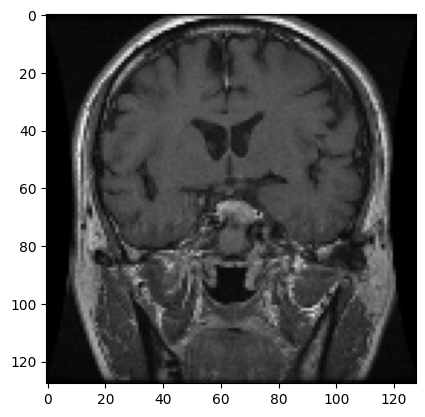

In [ ]:
plt.imshow(X_real[100], cmap = 'gray')

In [ ]:
with h5py.File(path + 'Models/reconstructions_26072023.h5', "r") as f:
    X_reconst_train = np.array(f['X_reconst_train'])
    y_train = np.array(f['y_train'])
    X_reconst_test = np.array(f['X_reconst_test'])
    y_test = np.array(f['y_test'])

In [ ]:
X_reconst = np.concatenate([X_reconst_train, X_reconst_test])
y_reconst = np.concatenate([y_train, y_test])

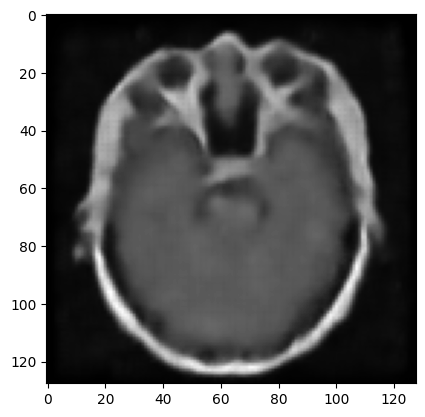

In [ ]:
plt.imshow(X_reconst_train[50].reshape((128,128)), cmap = 'gray')

# Procesamiento de las imagenes
Para utilizar EfficientNetB0, debemos convertir las imagenes de nuevo a RGB.

In [12]:
def transform_image(im):
  gray = cv2.cvtColor(im,cv2.COLOR_GRAY2RGB)
  norm_image = cv2.normalize(gray, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
  norm_image = norm_image.astype(np.uint8)
  return norm_image

In [ ]:
X_reconst = [transform_image(im.reshape((128,128))) for im in X_reconst]
X_reconst = np.array(X_reconst)

In [ ]:
X_reconst_train, X_reconst_test, y_reconst_train, y_reconst_test = train_test_split(X_reconst,y_reconst, test_size=0.1,random_state=101)

In [ ]:
X_real = np.array([transform_image(im) for im in X_real])

In [ ]:
X_train = np.array([transform_image(im) for im in X_train])
X_test = np.array([transform_image(im) for im in X_test])

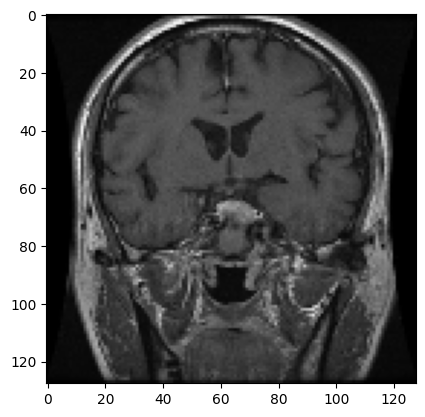

In [ ]:
plt.imshow(X_real[100], cmap = 'gray')

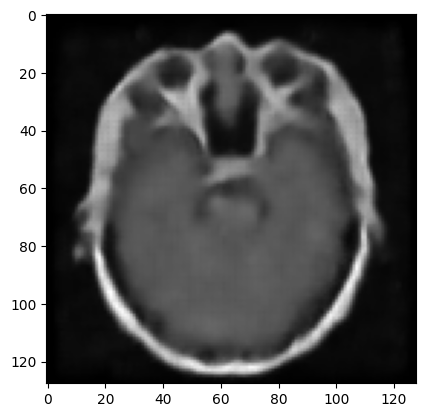

In [ ]:
plt.imshow(X_reconst[50], cmap = 'gray')

# Modelo de clasificación

Baseline

In [ ]:
model = make_classifier()
history = model.fit(X_train, y_train, validation_split=0.1, epochs =12, verbose=1, batch_size=32,)
#                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
83/83 [==============================] - 68s 151ms/step - loss: 0.5105 - accuracy: 0.8089 - val_loss: 0.8727 - val_accuracy: 0.7653
Epoch 2/12
83/83 [==============================] - 8s 95ms/step - loss: 0.2010 - accuracy: 0.9262 - val_loss: 0.2981 - val_accuracy: 0.9150
Epoch 3/12
83/83 [==============================] - 8s 99ms/step - loss: 0.1236 - accuracy: 0.9576 - val_loss: 0.2783 - val_accuracy: 0.9116
Epoch 4/12
83/83 [==============================] - 8s 97ms/step - loss: 0.0877 - accuracy: 0.9701 - val_loss: 0.3561 - val_accuracy: 0.8878
Epoch 5/12
83/83 [==============================] - 8s 98ms/step - loss: 0.0958 - accuracy: 0.9731 - val_loss: 0.2796 - val_accuracy: 0.9184
Epoch 6/12
83/83 [==============================] - 10s 126ms/step - loss: 0.0749 - accuracy: 0.9765 - val_loss: 0.3634 - val_accuracy: 0.8946
Epoch 7/12
83/83 [==============================] - 8s 92ms/step - loss: 0.0898 - accuracy: 0.9690 - val_loss: 0.1741 - val_accuracy: 0.9490
Epoch 8/1

Entrenamos y testeamos un moelo únicamente con las imagenes fake generadas por el CVAE

In [ ]:
model_fake = make_classifier()
history = model_fake.fit(X_reconst_train, y_reconst_train, validation_split=0.1, epochs =12, verbose=1, batch_size=32,)
#                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
83/83 [==============================] - 57s 176ms/step - loss: 0.6282 - accuracy: 0.7624 - val_loss: 0.6607 - val_accuracy: 0.7483
Epoch 2/12
83/83 [==============================] - 8s 95ms/step - loss: 0.2974 - accuracy: 0.8963 - val_loss: 0.4403 - val_accuracy: 0.8367
Epoch 3/12
83/83 [==============================] - 8s 95ms/step - loss: 0.1917 - accuracy: 0.9383 - val_loss: 0.5306 - val_accuracy: 0.8401
Epoch 4/12
83/83 [==============================] - 8s 94ms/step - loss: 0.1770 - accuracy: 0.9368 - val_loss: 0.6680 - val_accuracy: 0.8129
Epoch 5/12
83/83 [==============================] - 8s 98ms/step - loss: 0.1165 - accuracy: 0.9625 - val_loss: 0.5854 - val_accuracy: 0.8299
Epoch 6/12
83/83 [==============================] - 8s 92ms/step - loss: 0.0924 - accuracy: 0.9694 - val_loss: 0.4610 - val_accuracy: 0.9048
Epoch 7/12
83/83 [==============================] - 8s 96ms/step - loss: 0.0786 - accuracy: 0.9720 - val_loss: 0.6545 - val_accuracy: 0.8367
Epoch 8/12


Entrenamos un modelo con las imagenes reales y las imagenes fake generadas por el CVAE

In [ ]:
model_fake_real = make_classifier()
X_fake_real = np.concatenate([X_real, X_reconst])
y_fake_real = np.concatenate([y_real, y_reconst])

X_train_fake_real, X_test_fake_real, y_train_fake_real, y_test_fake_real = train_test_split(X_fake_real,y_fake_real, test_size=0.3,random_state=101)

history = model_fake_real.fit(X_train_fake_real, y_train_fake_real, validation_split=0.1, epochs =12, verbose=1, batch_size=32,)
#                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
129/129 [==============================] - 59s 116ms/step - loss: 0.6037 - accuracy: 0.7634 - val_loss: 0.6354 - val_accuracy: 0.8162
Epoch 2/12
129/129 [==============================] - 12s 94ms/step - loss: 0.2596 - accuracy: 0.9073 - val_loss: 0.5166 - val_accuracy: 0.8643
Epoch 3/12
129/129 [==============================] - 12s 96ms/step - loss: 0.1865 - accuracy: 0.9348 - val_loss: 0.4973 - val_accuracy: 0.8731
Epoch 4/12
129/129 [==============================] - 12s 95ms/step - loss: 0.1446 - accuracy: 0.9555 - val_loss: 0.3174 - val_accuracy: 0.8862
Epoch 5/12
129/129 [==============================] - 12s 92ms/step - loss: 0.1030 - accuracy: 0.9647 - val_loss: 0.2028 - val_accuracy: 0.9365
Epoch 6/12
129/129 [==============================] - 12s 94ms/step - loss: 0.0960 - accuracy: 0.9701 - val_loss: 0.2444 - val_accuracy: 0.9322
Epoch 7/12
129/129 [==============================] - 12s 95ms/step - loss: 0.0657 - accuracy: 0.9774 - val_loss: 0.2049 - val_accuracy

# Métricas

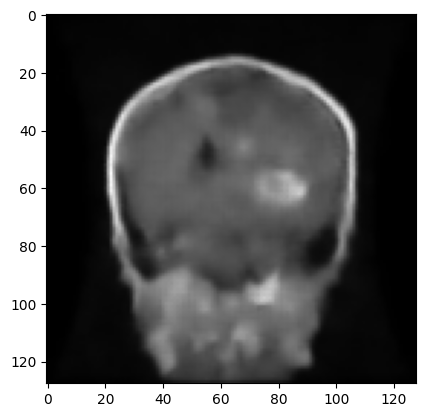

In [ ]:
plt.imshow(X_reconst_test[40])

In [ ]:
pred__train = predict_large_dataset(model, X_train)
pred_test = predict_large_dataset(model, X_test)

metrics = calculate_experiment_metrics(
    y_train,
    y_test,
    pred__train,
    pred_test,
    "baseline"
)

metrics

,accuracy_score,recall_score__micro,recall_score__macro,precision_score__micro,precision_score__macro,f1_score__micro,f1_score__macro,split,data_type
0,0.989105,0.989105,0.990131,0.989105,0.989494,0.989105,0.989750,train,baseline
1,0.951070,0.951070,0.958970,0.951070,0.956763,0.951070,0.956968,test,baseline


In [ ]:
pred_model_fake_train = predict_large_dataset(model_fake, X_reconst_train)
pred_model_fake_test = predict_large_dataset(model_fake, X_test)

fake_metrics = calculate_experiment_metrics(
    y_reconst_train,
    y_test,
    pred_model_fake_train,
    pred_model_fake_test,
    "fake"
)

fake_metrics


---    accuracy_score  recall_score__micro  recall_score__macro  \
0        0.979911             0.979911              0.98121   

   precision_score__micro  precision_score__macro  f1_score__micro  \
0                0.979911                0.980914         0.979911   

   f1_score__macro  split  
0         0.981045  train  

---    accuracy_score  recall_score__micro  recall_score__macro  \
0        0.522936             0.522936             0.567502   

   precision_score__micro  precision_score__macro  f1_score__micro  \
0                0.522936                0.719677         0.522936   

   f1_score__macro split  
0         0.499308  test  


,accuracy_score,recall_score__micro,recall_score__macro,precision_score__micro,precision_score__macro,f1_score__micro,f1_score__macro,split,data_type
0,0.979911,0.979911,0.981210,0.979911,0.980914,0.979911,0.981045,train,fake
1,0.522936,0.522936,0.567502,0.522936,0.719677,0.522936,0.499308,test,fake


In [ ]:
pred_model_fake_real_train = predict_large_dataset(model_fake_real, X_train_fake_real)
pred_model_fake_real_test = predict_large_dataset(model_fake_real, X_test)

fake_real_metrics = calculate_experiment_metrics(
    y_train_fake_real,
    y_test,
    pred_model_fake_real_train,
    pred_model_fake_real_test,
    "fake_real"
)

fake_real_metrics


---    accuracy_score  recall_score__micro  recall_score__macro  \
0        0.984679             0.984679             0.986571   

   precision_score__micro  precision_score__macro  f1_score__micro  \
0                0.984679                0.984487         0.984679   

   f1_score__macro  split  
0          0.98544  train  

---    accuracy_score  recall_score__micro  recall_score__macro  \
0        0.966361             0.966361             0.966389   

   precision_score__micro  precision_score__macro  f1_score__micro  \
0                0.966361                0.969986         0.966361   

   f1_score__macro split  
0         0.967913  test  


,accuracy_score,recall_score__micro,recall_score__macro,precision_score__micro,precision_score__macro,f1_score__micro,f1_score__macro,split,data_type
0,0.984679,0.984679,0.986571,0.984679,0.984487,0.984679,0.985440,train,fake_real
1,0.966361,0.966361,0.966389,0.966361,0.969986,0.966361,0.967913,test,fake_real


[Text(0.5, 1.0, 'Distribución categorías reales')]

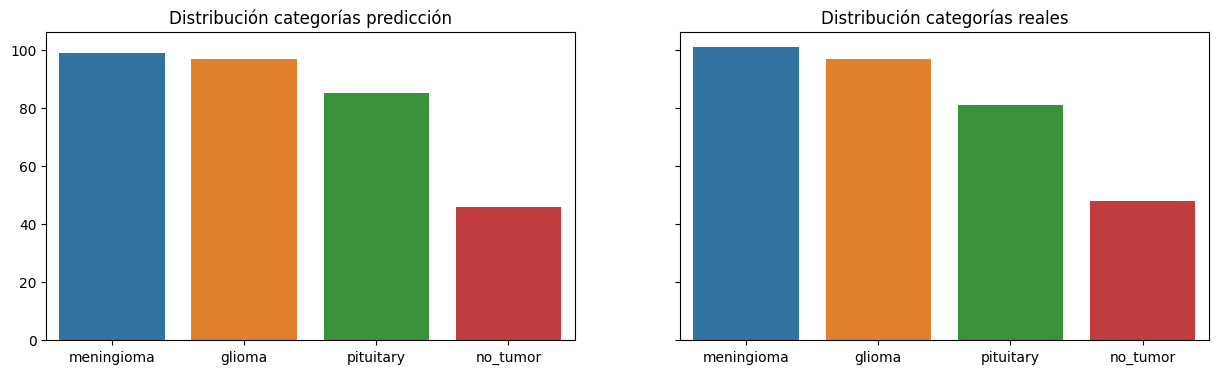

In [ ]:
import seaborn as sns

fig, axes = plt.subplots(ncols = 2, sharey = True, figsize = (15,4))
predicted = pd.Series(pred_model_fake_real_test).value_counts()
predicted.index = predicted.index.astype(str).str.replace('0','glioma').str.replace('1','no_tumor').str.replace( '2', 'meningioma').str.replace('3', 'pituitary')
sns.barplot(x = predicted.index, y = predicted, ax =  axes[0]).set(title = 'Distribución categorías predicción')

real = pd.Series(np.argmax(y_test, axis = 1)).value_counts()
real.index = real.index.astype(str).str.replace('0','glioma').str.replace('1','no_tumor').str.replace( '2', 'meningioma').str.replace('3', 'pituitary')
sns.barplot(x = real.index, y = real, ax =  axes[1]).set(title = 'Distribución categorías reales')

# Evaluación otros modelos

In [13]:
from glob import glob
fn = glob('/content/drive/MyDrive/Colab Notebooks/Talleres MML/Proyecto/data/' + 'fake/*')
data = {}
for f in fn:
  name = f.split('/')[-1].split('.h5')[0]
  with h5py.File(fn[1], "r") as f:
    X_train_ = np.array(f['X_train'])
    y_train_ = np.array(f['y_train'])

  X_train_ = np.array([transform_image(im) for im in X_train_])

  data[name] = {'X': X_train_, 'y': y_train_}

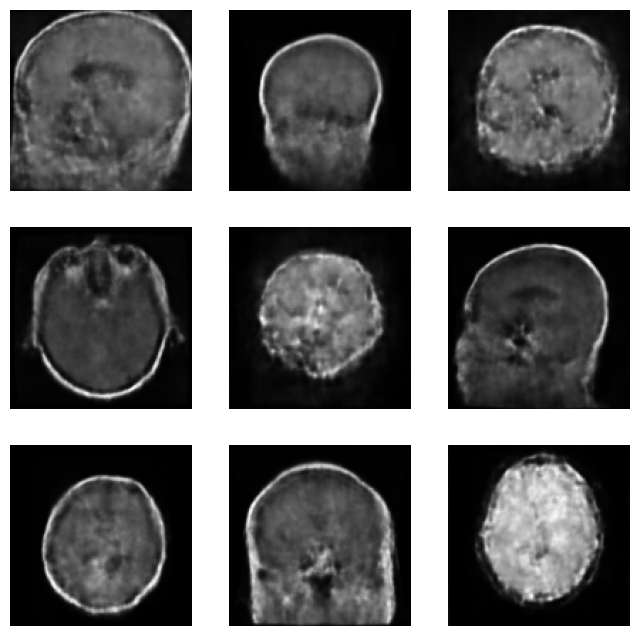

In [25]:
fig, axes = plt.subplots(ncols = 3, nrows = 3, figsize = (8,8))
data_to_plot =  data['fakedata_CVAE_small_256']['X']
for i, a in enumerate(axes.reshape((9))):
  a.imshow(data_to_plot[i], cmap = 'gray')
  a.axis('off')

In [ ]:
for k, i in data.items():
  X_train_ = i['X']
  y_train_ = i['y']
  print(X_train_.shape, y_train_.shape)

  model_ = make_classifier()
  model_.fit(X_train_, y_train_, validation_split=0.1, epochs =12, verbose=1, batch_size=32,)

  pred_train_ = predict_large_dataset(model_, X_train_)
  pred_test_ = predict_large_dataset(model_, X_test)

  metrics_ = calculate_experiment_metrics(
      y_train_,
      y_test,
      pred_train_,
      pred_test_,
      k
  )

  print(metrics_)
  metrics_.to_csv(f'metrics_{k}.csv')

(2937, 128, 128, 3) (2937, 4)
Epoch 1/12
83/83 [==============================] - 53s 123ms/step - loss: 1.1220 - accuracy: 0.5240 - val_loss: 1.4416 - val_accuracy: 0.4150
Epoch 2/12
83/83 [==============================] - 8s 95ms/step - loss: 0.9295 - accuracy: 0.6213 - val_loss: 1.0953 - val_accuracy: 0.5306
Epoch 3/12
83/83 [==============================] - 8s 98ms/step - loss: 0.7962 - accuracy: 0.6897 - val_loss: 1.1742 - val_accuracy: 0.5952
Epoch 4/12
83/83 [==============================] - 8s 96ms/step - loss: 0.6474 - accuracy: 0.7397 - val_loss: 1.1610 - val_accuracy: 0.5816
Epoch 5/12
83/83 [==============================] - 8s 94ms/step - loss: 0.5301 - accuracy: 0.7885 - val_loss: 1.6741 - val_accuracy: 0.4456
Epoch 6/12
83/83 [==============================] - 8s 97ms/step - loss: 0.4408 - accuracy: 0.8350 - val_loss: 1.2016 - val_accuracy: 0.5850
Epoch 7/12
83/83 [==============================] - 8s 93ms/step - loss: 0.3065 - accuracy: 0.8944 - val_loss: 1.2541 - va

In [ ]:
for k, i in data.items():
  X_train_ = i['X']
  y_train_ = i['y']
  print(X_train_.shape, y_train_.shape)

  model_fake_real = make_classifier()
  X_train_fake_real_ = np.concatenate([X_train, X_train_])
  y_train_fake_real_ = np.concatenate([y_train, y_train_])

  print(X_train_fake_real_.shape, y_train_fake_real_.shape)

  model_ = make_classifier()
  model_.fit(X_train_fake_real_, y_train_fake_real_, validation_split=0.1, epochs =12, verbose=1, batch_size=32,)

  pred_train_ = predict_large_dataset(model_, X_train_fake_real_)
  pred_test_ = predict_large_dataset(model_, X_test)

  metrics_ = calculate_experiment_metrics(
      y_train_fake_real_,
      y_test,
      pred_train_,
      pred_test_,
      k
  )

  print(metrics_)
  metrics_.to_csv(f'fake_and_real_metrics_{k}.csv')

(2937, 128, 128, 3) (2937, 4)
(5874, 128, 128, 3) (5874, 4)
Epoch 1/12
166/166 [==============================] - 74s 115ms/step - loss: 0.7568 - accuracy: 0.6971 - val_loss: 1.3200 - val_accuracy: 0.4371
Epoch 2/12
166/166 [==============================] - 16s 94ms/step - loss: 0.5351 - accuracy: 0.7885 - val_loss: 1.0182 - val_accuracy: 0.5595
Epoch 3/12
166/166 [==============================] - 16s 95ms/step - loss: 0.4508 - accuracy: 0.8210 - val_loss: 1.1434 - val_accuracy: 0.4915
Epoch 4/12
166/166 [==============================] - 16s 95ms/step - loss: 0.4114 - accuracy: 0.8435 - val_loss: 0.9286 - val_accuracy: 0.6037
Epoch 5/12
166/166 [==============================] - 16s 95ms/step - loss: 0.3495 - accuracy: 0.8630 - val_loss: 1.2314 - val_accuracy: 0.6429
Epoch 6/12
166/166 [==============================] - 16s 95ms/step - loss: 0.2851 - accuracy: 0.8907 - val_loss: 1.2316 - val_accuracy: 0.5952
Epoch 7/12
166/166 [==============================] - 16s 94ms/step - loss:

In [ ]:
pd.read_csv(f'metrics_{list(data.keys())[4]}.csv')

,Unnamed: 0,accuracy_score,recall_score__micro,recall_score__macro,precision_score__micro,precision_score__macro,f1_score__micro,f1_score__macro,split,data_type
0,0,0.903643,0.903643,0.894685,0.903643,0.914924,0.903643,0.902597,train,fakedata_CVAE_big_512
1,1,0.339450,0.339450,0.424584,0.339450,0.634303,0.339450,0.347382,test,fakedata_CVAE_big_512


In [ ]:
pd.read_csv(f'fake_and_real_metrics_{list(data.keys())[4]}.csv')

,Unnamed: 0,accuracy_score,recall_score__micro,recall_score__macro,precision_score__micro,precision_score__macro,f1_score__micro,f1_score__macro,split,data_type
0,0,0.934287,0.934287,0.935324,0.934287,0.938407,0.934287,0.935869,train,fakedata_CVAE_big_512
1,1,0.932722,0.932722,0.932863,0.932722,0.947610,0.932722,0.938445,test,fakedata_CVAE_big_512
